## Test Data Generation
This notebook contains some simple funtions to generate two different distributions of test data for CANOSP 2019

Currently there are two types of data generation:
    - `Blob` generation (data clustered around a point)
    - `Random` (no correlation)

A few functions have been created to generate samples that:
    - Contains N features
    - Contain M labels (species)
    
Finally, note that the format of the DataFrame returned by the generation functions is like this:

```
data_point_1_feat_1 data_point_1_feat_2, ...
data_point_2_feat_1 data_point_2_feat_2, ...
...
```

In [15]:
# Likely not needed...
%matplotlib inline

import numpy as np
from sklearn import datasets
from matplotlib import pyplot
import pandas as pd
import sklearn

### Graph params
Adjust these to control the paraeters used to generate the example graphs. Does not affect the function defs!

In [16]:
NUM_SAMPLES = 20000
NUM_LABELS = 3
NUM_FEATURES = 4
NUM_USERS = 100

# Used to control the range of values for the random gen func (1.0 --> [-1.0, 1.0])
RAND_FEAT_RANGE = 1.0
USERS_MIN_UNIQUE_LABELS = 2

In [26]:
def add_evenly_distributed_values_to_data(df, num_samples, num_items, field_name):
    new_field = [i % num_items for i in range(1, num_samples + 1)] # Avoid div by 0
    df[field_name] = new_field

def evenly_add_labels_to_data(df, num_samples, num_labels):
    add_evenly_distributed_values_to_data(df, num_samples, num_labels, "labels")
    
def add_users_ids_to_data_and_shuffle(df, num_samples, num_users):
    df = sklearn.utils.shuffle(df)
    add_evenly_distributed_values_to_data(df, num_samples, num_users, "user_id")
    return df
    
def all_users_have_at_least_n_unique_lables(data):
    nunique_labels = data.groupby("user_id", as_index=False).agg({"labels":"nunique"})
    ok = (nunique_labels['labels'] < USERS_MIN_UNIQUE_LABELS).sum() == 0
    
    if not ok:
        print("Not all users have {} unique labels! Regenerating!".format(USERS_MIN_UNIQUE_LABELS))
    return ok

def gen_data_until_prereq_met(data_gen_func, prereq_func):
    prereq_met = False
    df = None
    
    while not prereq_met:
        df = data_gen_func()
        prereq_met = prereq_func(df)
        
    return df
  

### Blob Data
Generates data where each species is centered around a point.

In [18]:
def gen_blob_data(num_samples, num_labels, num_features):
    '''
    Generates blob data, or data points that tend to cluster around a point for each label.
    Note that labels/species are interchangeable.
    Returns: A DataFrame where each column contains the feature for the data point.
    '''
    feat_arr, label_idxs = datasets.make_blobs(n_samples=num_samples,
                                               n_features=num_features,
                                               centers=num_labels)
    
    df = pd.DataFrame(feat_arr)
    df['labels'] = label_idxs
    return df

### Random Data
Generates data that is "psuedo" random. Anyways there should be no correlation between the features.

In [19]:
def gen_random_data(num_samples, num_labels, num_features):
    '''
    Generates random data where features should have no correlation.
    Note that labels/species are interchangeable.
    Returns: A DataFrame where each column contains the feature for the data point.
    '''
    df = pd.DataFrame()
    
    for i in range(0, num_features):
        feat_arr = np.random.ranf(num_samples) * RAND_FEAT_RANGE
        df[i] = feat_arr
    
    evenly_add_labels_to_data(df, num_samples, num_labels)
    return df


### Graphs
Just to visualize that the generation is doing it's job, we just threw together some scatterplot matrices.

Note that for whatever reason, assigning unique colours to species is not enabled by default, and it appears to be some work to have the matrix scatter plots use any different colours for different species. So for now, we're just settling for mono-colour plots. :)

In [20]:
def plot_scatter_matrix(data):
    '''
    Just wrap the call to improve readability niceness :)
    '''
    pd.plotting.scatter_matrix(data, alpha=0.2, figsize=(10, 10))

In [22]:
def gen_data_and_add_user_data(data_gen_func):
    def gen_and_add_users_func():
        data = data_gen_func(NUM_SAMPLES, NUM_LABELS, NUM_FEATURES)
        data = add_users_ids_to_data_and_shuffle(data, NUM_SAMPLES, NUM_USERS)
        return data
    
    return gen_data_until_prereq_met(gen_and_add_users_func, all_users_have_at_least_n_unique_lables)

#### Blob Plot

In [30]:
data = gen_data_and_add_user_data(gen_blob_data)

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


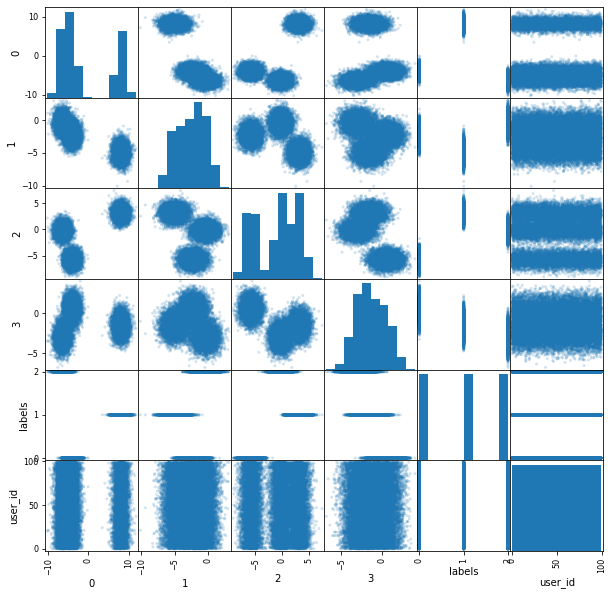

In [31]:
plot_scatter_matrix(data)

#### Random Plot

In [32]:
data = gen_data_and_add_user_data(gen_random_data)

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


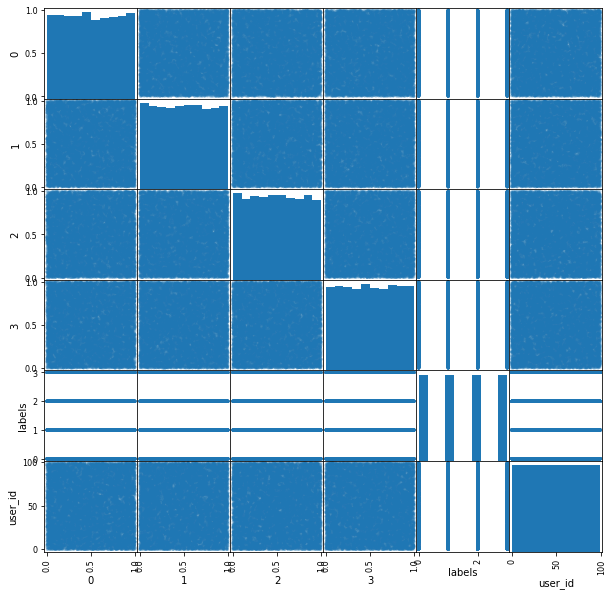

In [33]:
plot_scatter_matrix(data)

### Formating Data for Simulator Consumtion
While the current format of data is very nice for working with graphs, it may be a bit over complicated for working with directly. Here we transform the format into something more digestable for the simulator.

In [36]:
def transform_data_for_simulator_format(data):
    labels = []
    feats = []
    for i in range(NUM_USERS):
        client_df = df[df.user_id == i]
        labels.append(list(client_df.labels))
        client_feats = client_df.drop(columns=["user_id", "labels"]).to_records(index=False)
        feats.append(list(client_feats))
        
    return (labels, feats)

#### Example of How to Call the Transform Function

In [40]:
df = gen_data_and_add_user_data(gen_random_data)
labels, feats = transform_data_for_simulator_format(df)

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


### Unused Funcs

#### gen_clustered_data
Initially we tried using the make_classification function to generate clustered data. However, it became difficult to scale with different inputs since, internally, it has restraints on what `n_informative` can be set to depending on what other paremeters are set. In the end, we opted for blob generation mostly because it was simplier to use and did what we wanted to. However, later on we may want to revist this function if we find we need to test with different distributions of data as `make_classification` allows for more control.

In [10]:
def gen_clustered_data(tot_samples, num_labels, num_features):
    (feat_val_arrs, feat_idxs) = datasets.make_classification(n_samples=TOT_SAMPLES,
                                                         n_features=NUM_FEATURES,
                                                         n_classes=NUM_LABELS,
                                                         n_redundant=0,
                                                         n_repeated=0,
                                                         class_sep=0.5)
    df = pd.DataFrame(feat_val_arrs)
    df['labels'] = feat_idxs
        
    return df

#### gen_hist_of_features
Just an attempt to manually generate overlaping histograms for each species. (Defaults to using separate colours for each overlapping histogram, how about that!). The scatter matrix automatically generates a histogram on the diagonal, so this is kind of no longer needed.

In [11]:
def gen_hist_of_features(df):
    thing = df.pivot(columns='labels', values=0)
    pyplot.hist(thing, alpha=0.5)

    pyplot.legend(loc='upper right')
    pyplot.show()